In [524]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [525]:
df = pd.read_csv('supermarket.csv')

In [526]:
df.head(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200734,20071019,6,8,1,9.50,PRD0901335,CL00058,DEP00016,G00006,...,XX,OT,994108000679877,M,MM,Small Shop,Fresh,STORE00001,LS,E02
1,200805,20080328,6,21,1,1.49,PRD0901120,CL00162,DEP00055,G00016,...,XX,NaN,994110300629787,S,MM,Small Shop,Fresh,STORE00001,LS,E02
2,200716,20070612,3,9,1,0.86,PRD0900963,CL00248,DEP00089,G00030,...,NaN,NaN,994106200026009,S,MM,Small Shop,Grocery,STORE00001,LS,E02


In [527]:
# df['SHOP_DATE'] = df['SHOP_DATE'].astype(str)

# df['SHOP_DATE'] = df['SHOP_DATE'].astype(str)
# df['shop_year'] = df['SHOP_DATE'].str[:4].astype(int)
# df['shop_month'] = df['SHOP_DATE'].str[4:6].astype(int)
# df['shop_day'] = df['SHOP_DATE'].str[4:6].astype(int)
# df['SHOP_DATE'] = df['SHOP_DATE'].astype(int)
# df.head()

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [529]:
maxdate = df['SHOP_DATE'].max()
print(maxdate)

20080706


In [530]:
start_date = pd.to_datetime('2007-07-06', format='%Y-%m-%d')  # Convert start date to datetime64[ns]

df.dropna(subset=['CUST_CODE'], inplace=True)  # Drop rows with missing values in 'CUST_CODE'
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')  # Convert 'SHOP_DATE' to datetime format

# df = df.loc[df['SHOP_DATE'] >= start_date]  # Filter rows based on the start date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492494 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SHOP_WEEK                 492494 non-null  int64         
 1   SHOP_DATE                 492494 non-null  datetime64[ns]
 2   SHOP_WEEKDAY              492494 non-null  int64         
 3   SHOP_HOUR                 492494 non-null  int64         
 4   QUANTITY                  492494 non-null  int64         
 5   SPEND                     492494 non-null  float64       
 6   PROD_CODE                 492494 non-null  object        
 7   PROD_CODE_10              492494 non-null  object        
 8   PROD_CODE_20              492494 non-null  object        
 9   PROD_CODE_30              492494 non-null  object        
 10  PROD_CODE_40              492494 non-null  object        
 11  CUST_CODE                 492494 non-null  object        
 12  CU

In [531]:
df.head(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200734,2007-10-19,6,8,1,9.50,PRD0901335,CL00058,DEP00016,G00006,...,XX,OT,994108000679877,M,MM,Small Shop,Fresh,STORE00001,LS,E02
1,200805,2008-03-28,6,21,1,1.49,PRD0901120,CL00162,DEP00055,G00016,...,XX,NaN,994110300629787,S,MM,Small Shop,Fresh,STORE00001,LS,E02
1115,200815,2008-06-05,5,15,1,0.70,PRD0904509,CL00093,DEP00028,G00008,...,LA,OF,994111300258138,L,LA,Top Up,Grocery,STORE00001,LS,E02


In [532]:
df_bkt_unique = df.drop_duplicates(subset=['CUST_CODE', 'BASKET_ID'])
df_bkt_unique['CUST_LIFESTAGE'] = df_bkt_unique['CUST_LIFESTAGE'].fillna('XX')
df_bkt_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65159 entries, 0 to 578057
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SHOP_WEEK                 65159 non-null  int64         
 1   SHOP_DATE                 65159 non-null  datetime64[ns]
 2   SHOP_WEEKDAY              65159 non-null  int64         
 3   SHOP_HOUR                 65159 non-null  int64         
 4   QUANTITY                  65159 non-null  int64         
 5   SPEND                     65159 non-null  float64       
 6   PROD_CODE                 65159 non-null  object        
 7   PROD_CODE_10              65159 non-null  object        
 8   PROD_CODE_20              65159 non-null  object        
 9   PROD_CODE_30              65159 non-null  object        
 10  PROD_CODE_40              65159 non-null  object        
 11  CUST_CODE                 65159 non-null  object        
 12  CUST_PRICE_SENSIT

In [533]:
def create_proportion(df, col):
    # Group by ID and count unique strings
    grouped = df.groupby('CUST_CODE')[col].value_counts().unstack(fill_value=0)

    # Calculate total string counts for each ID
    grouped['Total'] = grouped.sum(axis=1)

    # Calculate proportion columns
    unique_strings = grouped.columns[:-1]
    proportion_columns = [f'{col}_{string}' for string in unique_strings]
    grouped[proportion_columns] = grouped[unique_strings].div(grouped['Total'], axis=0)

    # Reset the index if desired
    grouped.reset_index(inplace=True)

    # Select only the 'ID' column and proportion columns
    result = grouped[['CUST_CODE'] + proportion_columns]

    return result

In [534]:
df_bkt_cuslife = create_proportion(df_bkt_unique, 'CUST_LIFESTAGE')
df_bkt_cuslife.head(3)

CUST_LIFESTAGE,CUST_CODE,CUST_LIFESTAGE_OA,CUST_LIFESTAGE_OF,CUST_LIFESTAGE_OT,CUST_LIFESTAGE_PE,CUST_LIFESTAGE_XX,CUST_LIFESTAGE_YA,CUST_LIFESTAGE_YF
0,CUST0000000181,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,CUST0000000689,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,CUST0000000998,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [535]:
df_bkt_type = create_proportion(df_bkt_unique, 'BASKET_TYPE')
df_bkt_type.head(3)

BASKET_TYPE,CUST_CODE,BASKET_TYPE_Full Shop,BASKET_TYPE_Small Shop,BASKET_TYPE_Top Up,BASKET_TYPE_XX
0,CUST0000000181,0.0000,1.0000,0.00,0.0
1,CUST0000000689,0.4375,0.3125,0.25,0.0
2,CUST0000000998,0.0000,1.0000,0.00,0.0


In [536]:
df_bkt_dom = create_proportion(df_bkt_unique, 'BASKET_DOMINANT_MISSION')
df_bkt_dom.head(3)

BASKET_DOMINANT_MISSION,CUST_CODE,BASKET_DOMINANT_MISSION_Fresh,BASKET_DOMINANT_MISSION_Grocery,BASKET_DOMINANT_MISSION_Mixed,BASKET_DOMINANT_MISSION_Nonfood,BASKET_DOMINANT_MISSION_XX
0,CUST0000000181,1.0000,0.000000,0.0000,0.000000,0.0
1,CUST0000000689,0.3125,0.187500,0.4375,0.062500,0.0
2,CUST0000000998,0.0000,0.666667,0.0000,0.333333,0.0


In [537]:
df_bkt_sen = create_proportion(df_bkt_unique, 'BASKET_PRICE_SENSITIVITY')
df_bkt_sen.tail(3)

BASKET_PRICE_SENSITIVITY,CUST_CODE,BASKET_PRICE_SENSITIVITY_LA,BASKET_PRICE_SENSITIVITY_MM,BASKET_PRICE_SENSITIVITY_UM,BASKET_PRICE_SENSITIVITY_XX
3436,CUST0000999593,0.300000,0.633333,0.066667,0.000000
3437,CUST0000999935,0.666667,0.285714,0.000000,0.047619
3438,CUST0000999936,0.166667,0.666667,0.166667,0.000000


In [580]:
df_bkt_size = create_proportion(df_bkt_unique, 'BASKET_SIZE')
df_bkt_size.tail(3)

BASKET_SIZE,CUST_CODE,BASKET_SIZE_L,BASKET_SIZE_M,BASKET_SIZE_S
3436,CUST0000999593,0.666667,0.233333,0.100000
3437,CUST0000999935,0.571429,0.238095,0.190476
3438,CUST0000999936,0.000000,0.500000,0.500000


In [538]:
df_group = df.groupby('CUST_CODE').agg({'SHOP_DATE': lambda x: (df['SHOP_DATE'].max() - x.max()).days,
                            'SPEND': lambda x: x.sum(),
                            'BASKET_ID': lambda x: x.nunique()
                            }).reset_index()

df_group.columns=['CUST_CODE','recency','total_spent', 'num_bkt']

# Average Order Value
df_group['bkt_size']=df_group['total_spent']/df_group['num_bkt']

# Purchase Frequency
purchase_frequency=sum(df_group['num_bkt'])/df_group.shape[0]

# Repeat Rate
repeat_rate=df_group[df_group.num_bkt > 1].shape[0]/df_group.shape[0]

#Churn Rate
churn_rate=1-repeat_rate

# Customer Value
df_group['clv']=(df_group['bkt_size']*purchase_frequency)/churn_rate

# Time Between Purchase
customer_lifespan = (df['SHOP_DATE'].max() - df['SHOP_DATE'].min()).days
df_group['tbp'] = customer_lifespan/df_group['num_bkt']

df_group.tail(3)

,CUST_CODE,recency,total_spent,num_bkt,bkt_size,clv,tbp
3436,CUST0000999593,95,453.58,30,15.119333,963.011379,27.266667
3437,CUST0000999935,31,444.17,21,21.150952,1347.189547,38.952381
3438,CUST0000999936,80,17.67,6,2.945000,187.578939,136.333333


In [539]:
# repeat_purchase_rate = len(df_bkt_sum.groupby('CUST_CODE').filter(lambda x: len(x) > 1)) / len(df_bkt_sum['CUST_CODE'].unique())

# cltv = pd.DataFrame()
# cltv['CUST_CODE'] = df_total_spend['CUST_CODE']
# cltv['cltv'] = (df_total_spend['total_spend'] / df_bkt_size['bkt_size']) * df_bkt_count['bkt_count'] * repeat_purchase_rate * customer_lifespan
# cltv.head(3)

In [540]:
# cust_id = list()
# mtbp = list()

# for i in df['CUST_CODE'].unique():
#     df_filter = df[df['CUST_CODE']==i]
#     tbp = df_filter['SHOP_DATE'].max() - df_filter['SHOP_DATE'].min()
#     freq = df_bkt_count[df_bkt_count['CUST_CODE']==i]['bkt_count']
#     cust_id.append(i)
#     mtbp.append(tbp / freq)

In [612]:
df_scv = pd.merge(df_group, df_bkt_type, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_dom, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_sen, on='CUST_CODE')
df_scv = pd.merge(df_scv, df_bkt_size, on='CUST_CODE')
# df_scv = pd.merge(df_scv, df_bkt_cuslife, on='CUST_CODE')

df_scv.head(3)

,CUST_CODE,recency,total_spent,num_bkt,bkt_size,clv,tbp,BASKET_TYPE_Full Shop,BASKET_TYPE_Small Shop,BASKET_TYPE_Top Up,...,BASKET_DOMINANT_MISSION_Mixed,BASKET_DOMINANT_MISSION_Nonfood,BASKET_DOMINANT_MISSION_XX,BASKET_PRICE_SENSITIVITY_LA,BASKET_PRICE_SENSITIVITY_MM,BASKET_PRICE_SENSITIVITY_UM,BASKET_PRICE_SENSITIVITY_XX,BASKET_SIZE_L,BASKET_SIZE_M,BASKET_SIZE_S
0,CUST0000000181,547,2.44,1,2.440000,155.413451,818.000000,0.0000,1.0000,0.00,...,0.0000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,0.000000,1.000000
1,CUST0000000689,13,328.57,16,20.535625,1307.996862,51.125000,0.4375,0.3125,0.25,...,0.4375,0.062500,0.0,0.375000,0.625000,0.000000,0.0,0.5625,0.250000,0.187500
2,CUST0000000998,730,5.95,3,1.983333,126.326507,272.666667,0.0000,1.0000,0.00,...,0.0000,0.333333,0.0,0.333333,0.333333,0.333333,0.0,0.0000,0.333333,0.666667


In [613]:
X = df_scv.drop(columns='CUST_CODE')

In [614]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[6.68704156e-01, 2.93419790e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.58924205e-02, 3.96732535e-02, 2.40770465e-02, ...,
        5.62500000e-01, 2.50000000e-01, 1.87500000e-01],
       [8.92420538e-01, 7.17248374e-04, 3.21027287e-03, ...,
        0.00000000e+00, 3.33333333e-01, 6.66666667e-01],
       ...,
       [1.16136919e-01, 5.47680716e-02, 4.65489567e-02, ...,
        6.66666667e-01, 2.33333333e-01, 1.00000000e-01],
       [3.78973105e-02, 5.36318246e-02, 3.21027287e-02, ...,
        5.71428571e-01, 2.38095238e-01, 1.90476190e-01],
       [9.77995110e-02, 2.13242530e-03, 8.02568218e-03, ...,
        0.00000000e+00, 5.00000000e-01, 5.00000000e-01]])

In [615]:
# k_values = range(1, 10)
# inertia_values = []
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

# # Plot the inertia values
# plt.plot(k_values, inertia_values, marker='o')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Sum of squared distances')
# plt.title('Elbow Method')
# plt.show()

In [616]:
for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Print the silhouette score
    print(f"Silhouette Score k={k} : {silhouette_avg}")

Silhouette Score k=2 : 0.21568006132493112
Silhouette Score k=3 : 0.18041098478686168
Silhouette Score k=4 : 0.17635572806723435
Silhouette Score k=5 : 0.1842967917976654


In [617]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_scv['Cluster'] = labels
df_scv.head(3)

,CUST_CODE,recency,total_spent,num_bkt,bkt_size,clv,tbp,BASKET_TYPE_Full Shop,BASKET_TYPE_Small Shop,BASKET_TYPE_Top Up,...,BASKET_DOMINANT_MISSION_Nonfood,BASKET_DOMINANT_MISSION_XX,BASKET_PRICE_SENSITIVITY_LA,BASKET_PRICE_SENSITIVITY_MM,BASKET_PRICE_SENSITIVITY_UM,BASKET_PRICE_SENSITIVITY_XX,BASKET_SIZE_L,BASKET_SIZE_M,BASKET_SIZE_S,Cluster
0,CUST0000000181,547,2.44,1,2.440000,155.413451,818.000000,0.0000,1.0000,0.00,...,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,0.000000,1.000000,2
1,CUST0000000689,13,328.57,16,20.535625,1307.996862,51.125000,0.4375,0.3125,0.25,...,0.062500,0.0,0.375000,0.625000,0.000000,0.0,0.5625,0.250000,0.187500,1
2,CUST0000000998,730,5.95,3,1.983333,126.326507,272.666667,0.0000,1.0000,0.00,...,0.333333,0.0,0.333333,0.333333,0.333333,0.0,0.0000,0.333333,0.666667,2


In [618]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_scv.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature BASKET_SIZE_L, Importance score: 0.19256460599312042
Rank 2: Feature BASKET_SIZE_M, Importance score: 0.1595391372907953
Rank 3: Feature BASKET_SIZE_S, Importance score: 0.1562375441467267
Rank 4: Feature BASKET_TYPE_Small Shop, Importance score: 0.12430213463011004
Rank 5: Feature bkt_size, Importance score: 0.07905945294517552
Rank 6: Feature clv, Importance score: 0.06533121602695595
Rank 7: Feature total_spent, Importance score: 0.04760895483008596
Rank 8: Feature BASKET_TYPE_Top Up, Importance score: 0.03963586199760038
Rank 9: Feature BASKET_DOMINANT_MISSION_Mixed, Importance score: 0.026384710769870732
Rank 10: Feature BASKET_TYPE_Full Shop, Importance score: 0.02184990486057441
Rank 11: Feature BASKET_PRICE_SENSITIVITY_MM, Importance score: 0.0169422327018274
Rank 12: Feature BASKET_DOMINANT_MISSION_Fresh, Importance score: 0.013661484650877537
Rank 13: Feature BASKET_DOMINANT_MISSION_Grocery, Importance score: 0.01246224685062657
Rank 14: Feature BASKET_PRICE_S

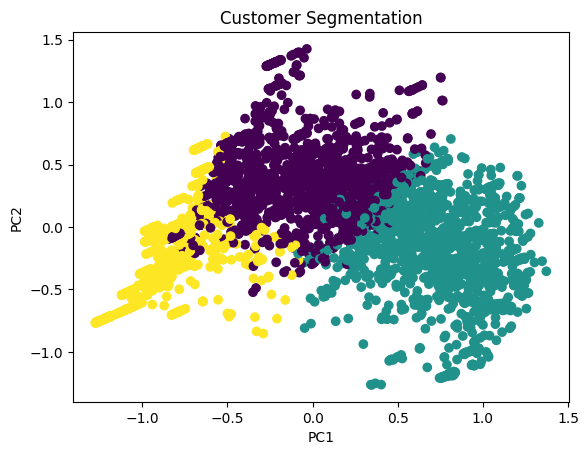

In [619]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), title='Labels')

# Show the plot
plt.show()

In [620]:
def des_clus(cluster):
    print(f'cluster {cluster}')
    print(f"{df_scv.loc[df_scv['Cluster']==cluster, ['recency',	'total_spent', 'num_bkt', 'bkt_size', 'clv', 'tbp']].mean()}\n")

In [621]:
des_clus(0)
des_clus(1)
des_clus(2)

cluster 0
recency        196.793544
total_spent    209.182215
num_bkt         24.247748
bkt_size         8.060393
clv            513.398967
tbp            298.191797
dtype: float64

cluster 1
recency         195.364810
total_spent     535.517280
num_bkt          24.190476
bkt_size         25.304133
clv            1611.722372
tbp             290.885766
dtype: float64

cluster 2
recency        324.180876
total_spent      8.446210
num_bkt          3.328341
bkt_size         2.289296
clv            145.814483
tbp            563.012726
dtype: float64



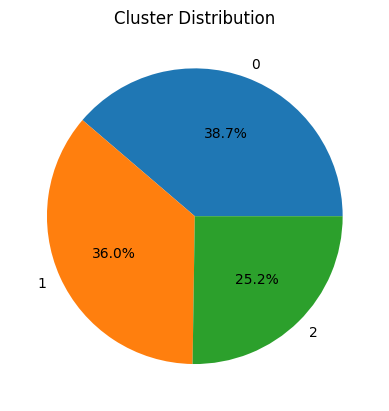

In [622]:
cluster_counts = df_scv['Cluster'].value_counts()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

In [631]:
def pd_rec(cluster): # product recomend by cluster
  c = df[df['CUST_CODE'].isin(df_scv.loc[df_scv['Cluster']==cluster]['CUST_CODE'])]
  basket = c.groupby(['BASKET_ID', 'PROD_CODE_20'])['QUANTITY'].sum().unstack().reset_index().fillna(0).set_index('BASKET_ID')
  def encode_units(x):
      if x <= 0:
          return 0
      if x >= 1:
          return 1
  basket_encode = basket.applymap(encode_units)

  basket_filter = basket_encode[(basket_encode > 0).sum(axis=1)>=2]

  frequent_itemsets = apriori(basket_filter, min_support=0.05, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
  frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

  display(association_rules(frequent_itemsets, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True))

In [632]:
pd_rec(0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DEP00010),(DEP00011),0.097873,0.269446,0.050284,0.513769,1.906760,0.023913,1.502484,0.527144
1,(DEP00011),(DEP00010),0.269446,0.097873,0.050284,0.186621,1.906760,0.023913,1.109110,0.650945
2,(DEP00008),(DEP00010),0.282965,0.097873,0.051000,0.180235,1.841516,0.023306,1.100470,0.637304
3,(DEP00010),(DEP00008),0.097873,0.282965,0.051000,0.521084,1.841516,0.023306,1.497206,0.506547
4,"(DEP00019, DEP00008)",(DEP00011),0.132617,0.269446,0.063719,0.480470,1.783176,0.027985,1.406182,0.506354
...,...,...,...,...,...,...,...,...,...,...
61,(DEP00076),(DEP00019),0.119899,0.406317,0.051337,0.428170,1.053783,0.002620,1.038216,0.057991
62,(DEP00011),(DEP00022),0.269446,0.237608,0.067340,0.249922,1.051825,0.003318,1.016417,0.067444
63,(DEP00022),(DEP00011),0.237608,0.269446,0.067340,0.283410,1.051825,0.003318,1.019487,0.064627
64,(DEP00019),(DEP00054),0.406317,0.132365,0.054748,0.134743,1.017967,0.000966,1.002749,0.029730


In [633]:
pd_rec(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(DEP00011, DEP00019, DEP00067)","(DEP00046, DEP00008)",0.171243,0.155676,0.056418,0.329463,2.116345,0.029760,1.259177,0.636480
1,"(DEP00046, DEP00008)","(DEP00011, DEP00019, DEP00067)",0.155676,0.171243,0.056418,0.362410,2.116345,0.029760,1.299826,0.624745
2,"(DEP00011, DEP00067)","(DEP00046, DEP00019, DEP00008)",0.238990,0.113287,0.056418,0.236070,2.083823,0.029344,1.160725,0.683451
3,"(DEP00046, DEP00019, DEP00008)","(DEP00011, DEP00067)",0.113287,0.238990,0.056418,0.498013,2.083823,0.029344,1.515996,0.586563
4,"(DEP00054, DEP00008)","(DEP00053, DEP00011)",0.157851,0.162578,0.052592,0.333175,2.049325,0.026929,1.255835,0.608010
...,...,...,...,...,...,...,...,...,...,...
6323,(DEP00076),"(DEP00019, DEP00021)",0.224135,0.229312,0.052892,0.235983,1.029092,0.001495,1.008732,0.036437
6324,(DEP00076),(DEP00052),0.224135,0.337385,0.076300,0.340418,1.008992,0.000680,1.004600,0.011486
6325,(DEP00052),(DEP00076),0.337385,0.224135,0.076300,0.226151,1.008992,0.000680,1.002604,0.013450
6326,"(DEP00022, DEP00019)",(DEP00076),0.245592,0.224135,0.055255,0.224989,1.003807,0.000210,1.001101,0.005027


In [634]:
pd_rec(2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DEP00055),(DEP00052),0.286541,0.296671,0.117221,0.409091,1.378936,0.032213,1.190248,0.385170
1,(DEP00052),(DEP00055),0.296671,0.286541,0.117221,0.395122,1.378936,0.032213,1.179508,0.390718
2,(DEP00022),(DEP00052),0.244573,0.296671,0.073806,0.301775,1.017203,0.001248,1.007309,0.022387
3,(DEP00052),(DEP00022),0.296671,0.244573,0.073806,0.248780,1.017203,0.001248,1.005601,0.024046
